In [1]:
!pip install -q kaggle
!pip install transformers
!pip install unidecode
!pip install torch
!pip install tqdm
!pip install transformers
!pip install livelossplot==0.5.4

In [2]:
import os 
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [6]:
from google.colab import files
from tqdm import tqdm
tqdm.pandas()
import pandas as pd
import numpy as np
from transformers import BertTokenizer
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"gabib3b","key":"817d7e169db4cbef867b22907320144c"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c home-depot-product-search-relevance

mkdir: cannot create directory ‘/root/.kaggle’: File exists
attributes.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
relevance_instructions.docx: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
product_descriptions.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!ls

 attributes.csv.zip   product_descriptions.csv.zip   sample_submission.csv.zip
'kaggle (1).json'     relevance_instructions.docx    test.csv.zip
 kaggle.json	      sample_data		     train.csv.zip


In [8]:
att_df= pd.read_csv('attributes.csv.zip')
desc_df= pd.read_csv('product_descriptions.csv.zip')
df = pd.read_csv('train.csv.zip', encoding='latin-1')
test_df = pd.read_csv('test.csv.zip',encoding='latin-1')


In [9]:
desc_df = desc_df.fillna(0)
df = df.fillna(0)

test_df = test_df.fillna(0)
att_df = att_df.fillna(0)

desc_df['product_uid'] = desc_df['product_uid'].astype(np.int64)
df['product_uid'] = df['product_uid'].astype(np.int64)
test_df['product_uid'] = test_df['product_uid'].astype(np.int64)
att_df['product_uid'] = att_df['product_uid'].astype(np.int64)

In [10]:
df.sample(2)

,id,product_uid,product_title,search_term,relevance
26262,80579,123538,32.5 in.x 32 in. Metal Gemstone Forest Wall Sc...,metal wall art,2.67
30206,92434,128292,Mont Blanc Northbrook Drop-in Composite Granit...,single bowl kitchen sinks 25 x 22 x 9,2.67


In [11]:
np.min(df['relevance'].tolist()), np.max(df['relevance'].tolist())

(1.0, 3.0)

In [37]:
unique_values = pd.unique(df['relevance']).tolist()
num_of_unique_values = len(unique_values)
sorted(unique_values), num_of_unique_values

([1.0, 1.25, 1.33, 1.5, 1.67, 1.75, 2.0, 2.25, 2.33, 2.5, 2.67, 2.75, 3.0], 13)

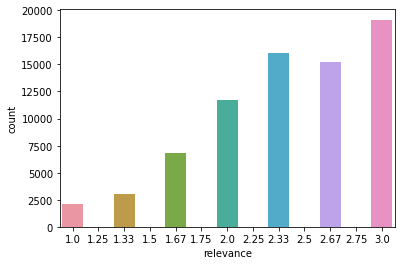

In [40]:
# np.bincount(df['relevance'].tolist(), minlength = num_of_unique_values)
ax = sns.countplot(x="relevance", data=df)


In [43]:
mapping = {1.25: 1.33, 1.5: 1.67, 1.75: 2.0, 2.25: 2.33, 2.5: 2.67, 2.75: 3.0}
df['relevance'] = df['relevance'].apply(lambda relevance: mapping[relevance] if relevance in mapping else relevance)

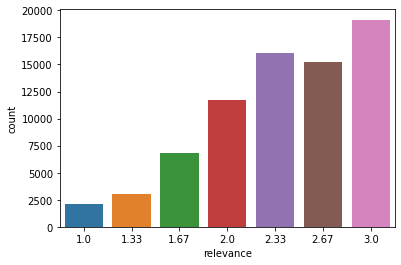

In [44]:
ax = sns.countplot(x="relevance", data=df)

In [13]:
df.describe()

,id,product_uid,relevance
count,74067.000000,74067.000000,74067.000000
mean,112385.709223,142331.911553,2.381634
std,64016.573650,30770.774864,0.533984
min,2.000000,100001.000000,1.000000
25%,57163.500000,115128.500000,2.000000
50%,113228.000000,137334.000000,2.330000
75%,168275.500000,166883.500000,3.000000
max,221473.000000,206650.000000,3.000000


In [15]:
from transformers import BertTokenizerFast
from transformers import BertTokenizer


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
MAX_SEARCH_TERM_LENGTH = 15
MAX_TITLE_LENGTH = 50

In [16]:
def tokenize(text, max_length):
  
  return tokenizer.encode_plus(
            text,
            max_length = max_length, 
            padding = 'max_length',
            truncation = True, 
            return_attention_mask = True, 
            add_special_tokens = True, 
            )
  


In [17]:
df['product_title_tokens'] = df['product_title'].progress_apply(lambda text: tokenize(text, MAX_TITLE_LENGTH))

100%|██████████| 74067/74067 [00:33<00:00, 2187.52it/s]


In [18]:
df['search_term_tokens'] = df['search_term'].progress_apply(lambda text: tokenize(text, MAX_SEARCH_TERM_LENGTH))

100%|██████████| 74067/74067 [00:16<00:00, 4365.58it/s]


In [19]:
test_df['product_title_tokens'] = test_df['product_title'].progress_apply(lambda text: tokenize(text, MAX_TITLE_LENGTH))

100%|██████████| 166693/166693 [01:15<00:00, 2215.03it/s]


In [20]:
test_df['search_term_tokens'] = test_df['search_term'].progress_apply(lambda text: tokenize(text, MAX_SEARCH_TERM_LENGTH))

100%|██████████| 166693/166693 [00:37<00:00, 4433.78it/s]


In [21]:
relevance_values = sorted(pd.unique(df['relevance']).tolist())
relevance_map = {relevance: index for (index, relevance) in enumerate(relevance_values)}
num_of_classes = len(relevance_map)
relevance_map, num_of_classes

({1.0: 0,
  1.25: 1,
  1.33: 2,
  1.5: 3,
  1.67: 4,
  1.75: 5,
  2.0: 6,
  2.25: 7,
  2.33: 8,
  2.5: 9,
  2.67: 10,
  2.75: 11,
  3.0: 12},
 13)

In [22]:
cls_to_score = {cls: score for (score, cls) in relevance_map.items()}
cls_to_score

{0: 1.0,
 1: 1.25,
 2: 1.33,
 3: 1.5,
 4: 1.67,
 5: 1.75,
 6: 2.0,
 7: 2.25,
 8: 2.33,
 9: 2.5,
 10: 2.67,
 11: 2.75,
 12: 3.0}

In [23]:

df['relevance_class'] = df['relevance'].apply(lambda relevance: relevance_map[relevance])
test_df['relevance_class'] = -1
pd.unique(df['relevance_class'])


array([12,  9,  8, 10,  6,  0,  4,  2,  1, 11,  5,  3,  7])

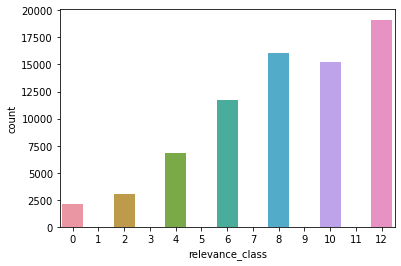

In [24]:
ax = sns.countplot(x="relevance_class", data=df)


In [25]:
num_of_classes = len(pd.unique(df['relevance_class']))
num_of_classes

13

In [31]:
np.bincount(df['relevance_class'].tolist())

array([ 2105,     4,  3006,     5,  6780,     9, 11730,    11, 16060,
          19, 15202,    11, 19125])

In [ ]:
  #  encoding = tokenizer.encode_plus(
  #     'he went home',
  #     add_special_tokens=True,
  #     max_length= 10,
  #     return_token_type_ids=False,
  #     padding="max_length",
  #     truncation=True,
  #     return_attention_mask=True,
  #     return_tensors='pt',
  #   )

In [31]:
test_df['relevance_class'] = -1

In [32]:
df.iloc[0]['search_term_tokens']

{'input_ids': [101, 6466, 21605, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [33]:
import random
import time
random.seed(int(time.time()))
from torch.utils.data import Dataset,DataLoader
import torch
from torch import nn, utils
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.optim.lr_scheduler import ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

class DatasetLoader(Dataset):

    def __init__(self, df):
        self._df = df


    def __len__(self):
        return len(self._df)
    def __getitem__(self, idx):
        row = self._df.iloc[idx]

        search_term = np.array(row['search_term_tokens']['input_ids'])
        search_term_attention_mask = np.array(row['search_term_tokens']['attention_mask'])
        product_title = np.array(row['product_title_tokens']['input_ids'])
        product_title_attention_mask = np.array(row['product_title_tokens']['attention_mask'])

   

        return row['id'], search_term, search_term_attention_mask, product_title, product_title_attention_mask, row['relevance_class']
    


In [34]:
df.sample(1)

,id,product_uid,product_title,search_term,relevance,product_title_tokens,search_term_tokens,relevance_class
17315,53428,113861,TechniSoil UltraMix Designer Series 50 lb. Charcoal Plum Blend Paver Joint Sand Bag,technisoil,3.0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]",12


In [35]:
from sklearn.model_selection import train_test_split



training_df, validation_df = train_test_split(df, test_size=0.1, random_state=42)
len(training_df)+ len(validation_df), len(df)


(74067, 74067)

In [37]:
BATCH_SIZE = 32

data_loader = DatasetLoader(training_df)

train_data_loader = torch.utils.data.DataLoader(data_loader,
                                                 batch_size=BATCH_SIZE, shuffle=True, 
                                                 num_workers=4,drop_last=False)



o_loader = DatasetLoader(training_df)

o_data_loader = torch.utils.data.DataLoader(o_loader,
                                                 batch_size=6, shuffle=True, 
                                                 num_workers=4,drop_last=False)



validation_data_df = validation_df[['id', 'product_title_tokens', 'search_term_tokens', 'relevance', 'relevance_class']]
validation_dataset = DatasetLoader(validation_data_df)

valiodation_data_loader = torch.utils.data.DataLoader(validation_dataset,
                                                 batch_size=BATCH_SIZE, shuffle=True, 
                                                 num_workers=4,drop_last=False)


test_df_fixed = test_df[(test_df['search_term_tokens'].map(len) > 0) & (test_df['product_title_tokens'].map(len) > 0)]
test_df_fixed['relevance_class'] = -1


test_loader = DatasetLoader(test_df_fixed[['id', 'product_title_tokens', 'search_term_tokens', 'relevance_class']])

test_data_loader = torch.utils.data.DataLoader(test_loader,
                                                 batch_size=BATCH_SIZE, shuffle=False, 
                                                 num_workers=4,drop_last=False)

len(data_loader), len(test_loader), len(o_data_loader)

(66660, 166693, 11110)

In [38]:
df.sample(1)

,id,product_uid,product_title,search_term,relevance,product_title_tokens,search_term_tokens,relevance_class
67704,203352,191637,Fan Essentials 1 ft. x 1-1/2 ft. West Virginia University 2-Sided Garden Flag with 3-2/3 ft. Metal Flagpole,milwalke brewers garden flag,2.67,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]",10


In [39]:
from transformers import BertConfig

# config = BertConfig.from_pretrained("bert-base-uncased",
#                                     output_hidden_states=True)

# bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
#                                          config=config)


In [40]:
from transformers import BertForSequenceClassification
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup


class RelevanceModel(nn.Module):

  def __init__(self, num_of_classes):
    super(RelevanceModel, self).__init__()
    config = BertConfig.from_pretrained("bert-base-uncased",
                                    output_hidden_states=True)

    BERT_MODEL_NAME = 'bert-base-cased'
    # self.bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

    self.bert.resize_token_embeddings(len(tokenizer))


    # for param in self.bert.parameters():
    #   param.requires_grad = False

    self.fc1 = nn.Linear(768 * 2, 512)
    self.fc2 = nn.Linear(512, num_of_classes)


  def  forward(self, queries, queries_masks, titles, titles_masks):
 
    encoded_queries = self.bert(queries, attention_mask=queries_masks)
    encoded_titles = self.bert(titles, attention_mask=titles_masks)


    out = torch.cat((encoded_queries.pooler_output, encoded_titles.pooler_output), 1)

    out = self.fc1(out)
    out = torch.relu(out)
    out = self.fc2(out)

    return out 


  def reset_parameters(self):
    nn.init.uniform_(self.fc1.weight)
    nn.init.uniform_(self.fc2.weight)


In [41]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
# query_encoder = EncoderModel(len(vocab))
# title_encoder = EncoderModel(len(vocab))

# query_encoder.reset_parameters()
# title_encoder.reset_parameters()

# #search_term, search_term_length, product_title, product_title_length
# query_encoded = query_encoder(search_term, search_term_length)
# title_encoded = query_encoder(product_title, product_title_length)
# torch.cat((query_encoded, title_encoded), 1)

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight('balanced', pd.unique(df['relevance_class']), df['relevance_class'].tolist())
# weights

In [44]:
counts = df.groupby("relevance_class").size().reset_index()
#total = np.sum(counts[0].tolist())

# [(row['relevance_class'],  row[0]/total) for (_, row) in counts[['relevance_class', 0]].iterrows()]

total = 0.0
for _, row in counts[['relevance_class', 0]].iterrows():
  total += row[0]
total 
weights1 = []
for _, row in counts[['relevance_class', 0]].iterrows():
  #print(row[0])
  cls = row['relevance_class']
  # print((cls, row[0]))
  sampeples_weight = (row[0] / total)
  required_weight = 1.0/len(counts)

  # print('-----')
  # print(sampeples_weight)
  # print(required_weight)
  x = required_weight/sampeples_weight
  # print(x)

  weight_for_class_a = (1 / row[0]) * total/len(counts)
  

   
  # weight = x * sampeples_weight
  # print(weight)
  # print('-------')

  weights1.append((cls, x))



weights1 = sorted(weights1, key = lambda x: x[0])
weights1 = [w[1] for w in weights1]
weights1
weights = weights1
weights

[2.7066325598392105,
 1424.3653846153848,
 1.8953631199140182,
 1139.4923076923078,
 0.8403335602450647,
 633.0512820512821,
 0.4857170962030298,
 517.951048951049,
 0.35476099243222536,
 299.8663967611337,
 0.37478368230900794,
 517.951048951049,
 0.2979064856711916]

In [45]:
from transformers import AutoModel, BertTokenizerFast

model = RelevanceModel(num_of_classes)
model.reset_parameters()
model.to(device)

#optimizer = torch.optim.Adam(model.parameters(), lr= 1e-5)
from transformers import AdamW

# define the optimizer
#optimizer = AdamW(model.parameters(),lr = 0.001)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001)

class_weights = torch.tensor(weights,dtype=torch.float)
criterion = torch.nn.CrossEntropyLoss(weight = class_weights, reduction='sum').to(device)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#  for ids, search_term, search_term_mask, product_title, product_title_mask, target_relevance_score  in train_data_loader:
#     search_term = Variable(search_term).to(device)
#     product_title = Variable(product_title).to(device)
#     search_term_mask = Variable(search_term_mask).to(device)
#     product_title_mask = Variable(product_title_mask).to(device)
#     target_relevance_score = Variable(target_relevance_score).long().to(device)
#     scores = model(search_term, search_term_mask,  product_title, product_title_mask)
#     break 

# scores.shape

In [46]:

def train_epoc(epoc):

  model.train()

  running_loss = 0.0
  counter = 0.0
  correct_classified = 0.0 
  for ids, search_term, search_term_mask, product_title, product_title_mask, target_relevance_score  in o_data_loader: #train_data_loader:
    search_term = Variable(search_term).to(device)
    product_title = Variable(product_title).to(device)
    target_relevance_score = Variable(target_relevance_score).long().to(device)

    search_term_mask = Variable(search_term_mask).to(device)
    product_title_mask = Variable(product_title_mask).to(device)
    

    optimizer.zero_grad()

    scores = model(search_term, search_term_mask,  product_title, product_title_mask)
    
    loss = criterion(scores, target_relevance_score)

    

    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    counter += search_term.shape[0]
    correct_classified += np.sum(torch.argmax(scores, dim=1).cpu().detach().numpy()== target_relevance_score.cpu().numpy())

  return running_loss/counter, correct_classified/counter



def validation():
  model.eval()

  running_loss  = 0.0
  counter = 0.0

  correct_classified = 0.0 

  with torch.no_grad():
    for ids, search_term, search_term_mask, product_title, product_title_mask, target_relevance_score in valiodation_data_loader:
      search_term = Variable(search_term).to(device)
      product_title = Variable(product_title).to(device)

      search_term_mask = Variable(search_term_mask).to(device)
      product_title_mask = Variable(product_title_mask).to(device)

      target_relevance_score = Variable(target_relevance_score).float().to(device)

      scores = model(search_term, search_term_mask,  product_title, product_title_mask)

    
      
      loss = criterion(scores, target_relevance_score.long())
      running_loss += loss.item()
      counter += search_term.shape[0]
      correct_classified += np.sum(torch.argmax(scores, dim=1).cpu().detach().numpy()== target_relevance_score.cpu().numpy())
  

  return running_loss/counter, correct_classified/counter  




In [ ]:
# for ids, search_term, search_term_mask, product_title, product_title_mask, target_relevance_score  in o_data_loader: #train_data_loader:
#   break

# # import os 

# # os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Variable(search_term).to(device)
# Variable(search_term_mask).to(device)
# Variable(product_title).to(device)
# Variable(product_title_mask).to(device)

In [47]:
from livelossplot import PlotLosses

liveloss = PlotLosses()

for epoc in range(1000):

  train_loss, train_accuracy = train_epoc(epoc)
  validation_loss, val_accuracy = 0, 0  #validation()

  liveloss.update({
          'train_loss': train_loss,
          'validation_loss': validation_loss,

          'train_accuracy': train_accuracy,
          'validation_accuracy': val_accuracy
      })
    
  liveloss.draw()

RuntimeError: ignored

In [ ]:
# for ids, search_term, search_term_mask, product_title, product_title_mask, target_relevance_score  in o_data_loader:
#   break

# search_term = Variable(search_term).to(device)
# product_title = Variable(product_title).to(device)

# search_term_mask = Variable(search_term_mask).to(device)
# product_title_mask = Variable(product_title_mask).to(device)

search_term.shape

torch.Size([6, 15])

In [ ]:
np.sum(torch.argmax(scores, dim=1).detach().cpu().numpy() == target_relevance_score.numpy())

13

In [ ]:
r1, scores.shape

NameError: ignored

In [81]:


model.eval()
test_scores = []
test_ids =[]
tt = []
BERT_MODEL_NAME = 'bert-base-cased'

bb = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True, output_hidden_states=False) #.to(device)
bb.resize_token_embeddings(len(tokenizer))

with torch.no_grad():
  for ids, search_term, search_term_mask, product_title, product_title_mask, target_relevance_score in train_data_loader:
    search_term = Variable(search_term)
    search_term_mask = Variable(search_term_mask)


    product_title = Variable(product_title)
    product_title_mask = Variable(product_title_mask)
    
    xx1 = bb(search_term, attention_mask=search_term_mask)
    xx2 = bb(product_title, attention_mask=product_title_mask)

    break
    # out = torch.cat((encoded_queries.pooler_output, encoded_titles.pooler_output), 1
  



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [79]:
out = torch.cat((xx1.pooler_output, xx2.pooler_output), 1)
out.shape, 768*2
                

(torch.Size([32, 1536]), 1536)

In [ ]:
xx.last_hidden_state.shape, xx.pooler_output.shape, len(xx.hidden_states[0])

(torch.Size([64, 5, 768]), torch.Size([64, 768]), 64)

In [67]:

for ids, search_term, search_term_mask, product_title, product_title_mask, target_relevance_score  in train_data_loader: #train_data_loader:
  break

search_term.shape, search_term_mask.shape

(torch.Size([32, 15]), torch.Size([32, 15]))

In [ ]:
# 166693, len(test_data), len(test_df)
all_ids = {x for (x, _) in test_data}

for _, row in test_df.iterrows():
  if row['id'] not in all_ids:
    test_data.append((row['id'], 1))
    
len(test_data)

166693

In [ ]:
yy = df.sample(10)[['product_title', 'search_term', 'relevance', 'relevance_class', 'product_title_tokens', 'search_term_tokens']]
yy

,product_title,search_term,relevance,relevance_class,product_title_tokens,search_term_tokens
6952,Delta Porter 4 in. Centerset 2-Handle High-Arc Bathroom Faucet in Oil Rubbed Bronze,Bronze bath rug,1.00,5,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
6394,Husky 8-Pocket Nail Pouch,nail bags,2.67,3,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
34189,RIDGID JobMax 12-Volt Multi-Tool Starter Kit,ridgid 12 volt,3.00,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
23924,MOEN Brantford Tank Lever in Brushed Nickel,moen brantford nickel,3.00,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
14101,WeatherStar 36 in. x 55 in. 2-Track Storm Aluminum Window,Aluminum track for windows,2.00,4,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
65139,DEWALT Harsh Condition Insulated Size Large Work Glove,Insulted work gloves,3.00,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
33636,A-C Draftshields 12 in. x 12 in. Vent Cover,8x22 a/c vent,1.33,7,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
70402,Commercial Electric 2 in. 45å¡ Sch. 40 Belled End Elbow,2 pipe 45,3.00,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
57216,Commercial Electric 11 in. Cable Tie - Natural (100-Pack),commercial smart tie,2.33,2,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
20838,Nature Power Bayport 72 in. Black Outdoor Solar Lamp Post with Super Bright Natural White LED,post lamp tier,2.67,3,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
i = 0
yy.iloc[i]['product_title'], tokenizer.convert_ids_to_tokens(yy.iloc[i]['product_title_tokens']['input_ids'])

('Delta Porter 4 in. Centerset 2-Handle High-Arc Bathroom Faucet in Oil Rubbed Bronze',
 ['[CLS]',
  'delta',
  'porter',
  '4',
  'in',
  '.',
  'centers',
  '##et',
  '2',
  '-',
  'handle',
  'high',
  '-',
  'arc',
  'bathroom',
  'fa',
  '##uce',
  '##t',
  'in',
  'oil',
  'rubbed',
  'bronze',
  '[SEP]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[P